In [38]:
import pandas as pd
import matplotlib as plt
import numpy as np 
%matplotlib inline

In [91]:
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import cross_validation, metrics

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

from xgboost.sklearn import XGBRegressor  

import scipy.stats as st

In [179]:
X_train = pd.read_csv("train.csv", index_col = 0)
X_test = pd.read_csv("test.csv", index_col = 0)
X_train['source'] = 'train'
X_test['source'] = 'test'
X = pd.concat([X_train, X_test], ignore_index = True)
print X_train.shape, X_test.shape, X.shape

(1460, 81) (1459, 80) (2919, 81)


In [180]:
#for c in X: print c," ",X[c].isnull().sum()

In [181]:
#for c in X: print c," ",X[c].dtypes

In [182]:
X.loc[X['BsmtFinSF1'].isnull()&X['BsmtFinType1'].isnull(), 'BsmtFinSF1'] = 0.0 
X.loc[X['BsmtFinSF2'].isnull()&X['BsmtFinType2'].isnull(), 'BsmtFinSF2'] = 0.0
X.drop(X[(X['BsmtFinSF1'] > 0) &(X['BsmtFinType1'].isnull())].index, inplace = True)
X.drop(X[(X['BsmtFinSF2'] > 0)&(X['BsmtFinType2'].isnull())].index, inplace = True)

X.loc[X['BsmtUnfSF'].isnull()&X['BsmtCond'].isnull(), 'BsmtUnfSF'] = 0.0  

X.loc[X['BsmtFullBath'].isnull()&X['BsmtCond'].isnull(), 'BsmtFullBath'] = 0.0 
X.loc[X['BsmtHalfBath'].isnull()&X['BsmtCond'].isnull(), 'BsmtHalfBath'] = 0.0 

X = X.drop(X[X['Electrical'].isnull()].index)

X = X[(~X['Exterior1st'].isnull()) & (~X['Exterior2nd'].isnull()) | (X['source'] == 'test')]

X = X[~X['Functional'].isnull()| (X['source'] == 'test')]

X.drop(X[(X['GarageCars'].isnull()|X['GarageArea'].isnull()) & (X['source'] != 'test')].index, inplace = True)

X.loc[X['GarageQual'].isnull(),'GarageYrBlt'] = 2011

X = X[~X['KitchenQual'].isnull() | (X['source'] == 'test')]
X = X[~X['MSZoning'].isnull() | (X['source'] == 'test')]
X['MasVnrType'] = X['MasVnrType'].replace(np.nan, 'None')
X.loc[(X['MasVnrType'] == 'None') & X['MasVnrArea'].isnull(), 'MasVnrArea'] = 0.0
#X.drop(X[(X['MasVnrArea'] > 0)&(X['MasVnrType'] == 'None')].index, inplace = True)
X.loc[X['SaleType'].isnull(),'SaleType'] = 'Oth'
X.loc[X['TotalBsmtSF'].isnull()&X['BsmtCond'].isnull(), 'TotalBsmtSF'] = 0.0  
X = X.drop(labels=['Utilities'], axis = 1)

X[X['source'] == 'test'].shape

(1459, 80)

In [183]:
from scipy.stats import mode

one_hot_cols = ['MSSubClass','MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MoSold', 'SaleType', 'SaleCondition']

X['MSSubClass'] = X['MSSubClass'].map({20:21, 30:21, 40:21, 45:51, 50:51, 60:51, 70:51, 75:51, 80:51, 85:51, 90:51, 120:121, 150:121, 160:121, 180:121, 190:121})

neighborhood_zoning = X.pivot_table(values='MSZoning', columns = 'Neighborhood', aggfunc=(lambda x:mode(x).mode[0]) )
print neighborhood_zoning
miss_bool = X['MSZoning'].isnull()
X.loc[miss_bool, 'MSZoning'] = X.loc[miss_bool,'Neighborhood'].apply(lambda x:neighborhood_zoning[x])

X['Alley'] = X['Alley'].replace(['Grvl', 'Pave'],'Access')
X['LotShape'] = X['LotShape'].map({'Reg':'Reg', 'IR1': 'IR', 'IR2': 'IR', 'IR3': 'IR'})
X['LandContour'] = X['LandContour'].replace(['HLS', 'Bnk', 'Low'], 'UnLvl')
X['LotConfig'] = X['LotConfig'].replace(['Corner','CulDSac', 'FR2','FR3'],'Outside')
X['LandSlope'] = X['LandSlope'].replace(['Mod', 'Sev'], 'UnGtl')
X.loc[X['Condition1']!= 'Norm','Condition1'] = 'Abnorm'
X.loc[X['Condition2']!= 'Norm','Condition2'] = 'Abnorm'
X.loc[(X['HouseStyle']!= '1Story')&(X['HouseStyle']!= '2Story'),'HouseStyle'] = 'Oth'
X.loc[(X['RoofStyle']!= 'Gable')&(X['RoofStyle']!= 'Hip'),'RoofStyle'] = 'Oth'
X.loc[X['MasVnrType']!= 'None','MasVnrType'] = 'Has'
X.loc[(X['Foundation']!= 'PConc')&(X['Foundation']!= 'CBlock'),'Foundation'] = 'Oth'
X.loc[X['Electrical']!= 'SBrkr','Electrical'] = 'Oth'
X['GarageType'] = X['GarageType'].replace(['Basment', '2Types', 'CarPort'],'Oth')





for c in one_hot_cols: print X[c].value_counts(dropna = False) 



Neighborhood Blmngtn Blueste BrDale BrkSide ClearCr CollgCr Crawfor Edwards  \
MSZoning          RL      RM     RM      RM      RL      RL      RL      RL   

Neighborhood Gilbert IDOTRR   ...   NoRidge NridgHt OldTown SWISU Sawyer  \
MSZoning          RL     RM   ...        RL      RL      RM    RL     RL   

Neighborhood SawyerW Somerst StoneBr Timber Veenker  
MSZoning          RL      FV      RL     RL      RL  

[1 rows x 25 columns]
51     1305
21     1223
121     389
Name: MSSubClass, dtype: int64
RL         2264
RM          463
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64
Pave    2905
Grvl      12
Name: Street, dtype: int64
NaN       2719
Access     198
Name: Alley, dtype: int64
Reg    1858
IR     1059
Name: LotShape, dtype: int64
Lvl      2620
UnLvl     297
Name: LandContour, dtype: int64
Inside     2131
Outside     786
Name: LotConfig, dtype: int64
Gtl      2776
UnGtl     141
Name: LandSlope, dtype: int64
NAmes      443
CollgCr    267
OldTown  

In [184]:
X = pd.get_dummies(X, columns = one_hot_cols, dummy_na = True)



In [185]:
X = X.fillna('NN')

In [186]:
ordered_val = ['Po', 'Fa', 'TA', 'Gd', 'Ex'] #NN
X[['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC' ,'KitchenQual', 'FireplaceQu', 'GarageQual' , 'GarageCond', 'PoolQC']] = X[['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC' ,'KitchenQual', 'FireplaceQu', 'GarageQual' , 'GarageCond', 'PoolQC']].apply(lambda x: x.astype('category', ordered = True, categories = ordered_val).cat.codes)

ordered_val = ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'] #NN
X[['BsmtFinType1', 'BsmtFinType2' ]] = X[['BsmtFinType1', 'BsmtFinType2' ]].apply(lambda x: x.astype('category', ordered = True, categories = ordered_val).cat.codes)

ordered_val = ['No', 'Mn', 'Av', 'Gd'] #NN
X['BsmtExposure'] = X['BsmtExposure'].astype('category', ordered = True, categories = ordered_val).cat.codes

ordered_val = ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
X['Functional'] = X['Functional'].astype('category', ordered = True, categories = ordered_val).cat.codes

ordered_val = ['Unf', 'RFn', 'Fin'] #NN
X['GarageFinish'] = X['GarageFinish'].astype('category', ordered = True, categories = ordered_val).cat.codes

ordered_val = ['N', 'P', 'Y'] #N
X['PavedDrive'] = X['PavedDrive'].astype('category', ordered = True, categories = ordered_val).cat.codes

ordered_val = [ 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'] #NN
X['Fence'] = X['Fence'].astype('category', ordered = True, categories = ordered_val).cat.codes



mapped_val = {'N' : 0, 'Y': 1}
X['CentralAir'] = X['CentralAir'].map(mapped_val)

mapped_val = {'NN' : 0, 'Elev':1 ,'Gar2':1 ,'Othr':1 ,'Shed':1 ,'TenC': 1}
X['MiscFeature'] = X['MiscFeature'].map(mapped_val)

f = lambda x: 2011 - x
X['YearBuilt'] = X['YearBuilt'].apply(f)
X['YearRemodAdd'] = X['YearRemodAdd'].apply(f)
X['GarageYrBlt'] = X['GarageYrBlt'].apply(f)
X['YearBuilt'] = X['YearBuilt'].apply(f)
X['YrSold'] = X['YrSold'].apply(f)





In [187]:
X['SalePrice'] = pd.to_numeric(X['SalePrice'], errors = 'coerce')
X = X.drop(labels = ['LotFrontage'], axis = 1)

In [188]:
X_train = X[X['source'] == 'train']
X_test = X[X['source'] == 'test']
X_train = X_train.drop(labels = ['source'], axis = 1)
X_test = X_test.drop(labels = ['source', 'SalePrice'], axis = 1)

In [189]:
for c in X_test.columns:
    X_test[c] = pd.to_numeric(X_test[c], errors = 'coerce')
    X_train[c] = pd.to_numeric(X_train[c], errors = 'coerce')
for c in X_test: print c," ",X_test[c].dtypes
for c in X_test: print c," ",X_test[c].isnull().sum()

1stFlrSF   int64
2ndFlrSF   int64
3SsnPorch   int64
BedroomAbvGr   int64
BsmtCond   int8
BsmtExposure   int8
BsmtFinSF1   float64
BsmtFinSF2   float64
BsmtFinType1   int8
BsmtFinType2   int8
BsmtFullBath   float64
BsmtHalfBath   float64
BsmtQual   int8
BsmtUnfSF   float64
CentralAir   int64
EnclosedPorch   int64
ExterCond   int8
ExterQual   int8
Fence   int8
FireplaceQu   int8
Fireplaces   int64
FullBath   int64
Functional   int8
GarageArea   float64
GarageCars   float64
GarageCond   int8
GarageFinish   int8
GarageQual   int8
GarageYrBlt   float64
GrLivArea   int64
HalfBath   int64
HeatingQC   int8
KitchenAbvGr   int64
KitchenQual   int8
LotArea   int64
LowQualFinSF   int64
MasVnrArea   float64
MiscFeature   int64
MiscVal   int64
OpenPorchSF   int64
OverallCond   int64
OverallQual   int64
PavedDrive   int8
PoolArea   int64
PoolQC   int8
ScreenPorch   int64
TotRmsAbvGrd   int64
TotalBsmtSF   float64
WoodDeckSF   int64
YearBuilt   int64
YearRemodAdd   int64
YrSold   int64
MSSubClass_21.0

MoSold_6.0   0
MoSold_7.0   0
MoSold_8.0   0
MoSold_9.0   0
MoSold_10.0   0
MoSold_11.0   0
MoSold_12.0   0
MoSold_nan   0
SaleType_COD   0
SaleType_CWD   0
SaleType_Con   0
SaleType_ConLD   0
SaleType_ConLI   0
SaleType_ConLw   0
SaleType_New   0
SaleType_Oth   0
SaleType_WD   0
SaleType_nan   0
SaleCondition_Abnorml   0
SaleCondition_AdjLand   0
SaleCondition_Alloca   0
SaleCondition_Family   0
SaleCondition_Normal   0
SaleCondition_Partial   0
SaleCondition_nan   0


In [190]:
X_test.fillna(0)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
1460,896,0,0,2,2,0,468.0,144.0,2,1,...,0,1,0,0,0,0,0,1,0,0
1461,1329,0,0,3,2,0,923.0,0.0,4,0,...,0,1,0,0,0,0,0,1,0,0
1462,928,701,0,3,2,0,791.0,0.0,5,0,...,0,1,0,0,0,0,0,1,0,0
1463,926,678,0,3,2,0,602.0,0.0,5,0,...,0,1,0,0,0,0,0,1,0,0
1464,1280,0,0,2,2,0,263.0,0.0,4,0,...,0,1,0,0,0,0,0,1,0,0
1465,763,892,0,3,2,0,0.0,0.0,0,0,...,0,1,0,0,0,0,0,1,0,0
1466,1187,0,0,3,2,0,935.0,0.0,4,0,...,0,1,0,0,0,0,0,1,0,0
1467,789,676,0,3,2,0,0.0,0.0,0,0,...,0,1,0,0,0,0,0,1,0,0
1468,1341,0,0,2,2,3,637.0,0.0,5,0,...,0,1,0,0,0,0,0,1,0,0
1469,882,0,0,2,2,0,804.0,78.0,4,2,...,0,1,0,0,0,0,0,1,0,0


In [191]:
y_train = X_train['SalePrice'].copy()
X_train = X_train.drop(labels = ['SalePrice'], axis = 1)
#X_train.to_csv('munged_train.csv', index = False)
#X_test.to_csv('munged_test.csv', index = False)

In [192]:

X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, test_size = 0.3, random_state = 0)

In [193]:
def modelfitscore(model, X_train_train, y_train_train, X_train_test, y_train_test):
    #scaler = preprocessing.RobustScaler().fit(X_train_train)
    #T_train = scaler.transform(X_train_train)
    #T_test = scaler.transform(X_train_test)
    
    model.fit(X_train_train, y_train_train)
    cv_score = cross_validation.cross_val_score(model, X_train_train, y_train_train, cv = 20, scoring = 'mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    prediction_train_test = model.predict(X_train_test)
    
    rmse = np.sqrt(metrics.mean_squared_error(y_train_test, prediction_train_test))
    #print "cv_score mean: %.4g" % np.mean(cv_score)
    print "rmse: %.4g" % rmse
    #print "oob score %.4g" % model.oob_score_
    print "test score %.4g" % model.score(X_train_test, y_train_test)

In [198]:
model = ensemble.RandomForestRegressor(oob_score = True, n_estimators = 300, random_state = 0, max_features = 2, min_samples_split = 5, bootstrap = True, max_depth = None, min_samples_leaf = 1)


#model = XGBRegressor()

In [199]:
modelfitscore(model, X_train_train, y_train_train, X_train_test, y_train_test)

/Users/kuncoro/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kuncoro/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kuncoro/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kuncoro/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


rmse: 3.745e+04
test score 0.7888


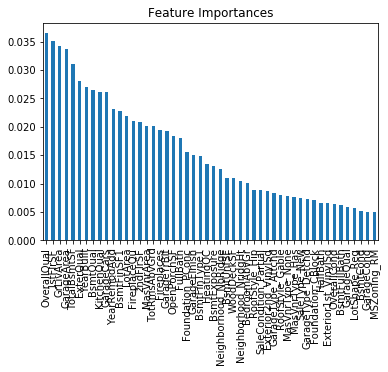

In [200]:
coef = pd.Series(model.feature_importances_, X_train_train.columns ).sort_values(ascending=False)
coef.nlargest(50).plot(kind = 'bar', title = "Feature Importances")

In [89]:
#model2 = ensemble.RandomForestRegressor(oob_score = True, n_estimators = 300, random_state = 0, max_features = 2, min_samples_split = 5, bootstrap = True, max_depth = None, min_samples_leaf = 1)
#predictors = pd.Series(coef.nlargest(20).index).tolist()
#modelfitscore(model2, X_train_train[predictors], y_train_train, X_train_test[predictors], y_train_test)

model2 = XGBRegressor()
predictors = pd.Series(coef.nlargest(47).index).tolist()
modelfitscore(model2, X_train_train[predictors], y_train_train, X_train_test[predictors], y_train_test)



/Users/kuncoro/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kuncoro/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kuncoro/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kuncoro/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


rmse: 2.606e+04
test score 0.8977


/Users/kuncoro/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


In [115]:
#model3 = ensemble.RandomForestRegressor( n_estimators = 300, random_state = 0, max_features = 3, min_samples_split = 2, bootstrap = False, max_depth = None, min_samples_leaf = 2)

param = {'reg_alpha': 66.853486590171968, 'colsample_bytree': 0.79162478276598092, 'learning_rate': 0.091303927909830093, 'min_child_weight': 5.566041462073227, 'n_estimators': 44, 'subsample': 0.73299057698250036, 'max_depth': 20, 'gamma': 3.3971980527497125}
model3 = XGBRegressor(**param)
predictors = pd.Series(coef.nlargest(45).index).tolist()
modelfitscore(model3, X_train_train[predictors], y_train_train, X_train_test[predictors], y_train_test)

/Users/kuncoro/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kuncoro/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kuncoro/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kuncoro/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


rmse: 2.576e+04
test score 0.9


/Users/kuncoro/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


In [92]:
# specify parameters and distributions to sample from
'''
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 20),
              "min_samples_split": randint(2, 20),
              "min_samples_leaf": randint(1, 20),
              "bootstrap": [True, False]}
'''
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

param_dist = {  
    "n_estimators": st.randint(3, 47),
    "max_depth": st.randint(3, 30),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(nthreads=-1)

# run randomized search
n_iter_search = 100

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            


In [93]:
predictors = pd.Series(coef.nlargest(47).index).tolist()
#model4 = ensemble.RandomForestRegressor( n_estimators = 300, random_state = 0)
model4 = XGBRegressor()
random_search = RandomizedSearchCV(model4, param_distributions=param_dist,
                                   n_iter=n_iter_search)
random_search.fit(X_train[predictors], y_train)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.878 (std: 0.021)
Parameters: {'reg_alpha': 66.853486590171968, 'colsample_bytree': 0.79162478276598092, 'learning_rate': 0.091303927909830093, 'min_child_weight': 5.566041462073227, 'n_estimators': 44, 'subsample': 0.73299057698250036, 'max_depth': 20, 'gamma': 3.3971980527497125}

Model with rank: 2
Mean validation score: 0.877 (std: 0.012)
Parameters: {'reg_alpha': 34.58863955873079, 'colsample_bytree': 0.9759930528560774, 'learning_rate': 0.18030477395646244, 'min_child_weight': 1.1483647319927122, 'n_estimators': 22, 'subsample': 0.84860431675517678, 'max_depth': 22, 'gamma': 6.0220813975748655}

Model with rank: 3
Mean validation score: 0.874 (std: 0.020)
Parameters: {'reg_alpha': 21.596697015365493, 'colsample_bytree': 0.95965470393188568, 'learning_rate': 0.25380811335561643, 'min_child_weight': 1.9515963769579481, 'n_estimators': 37, 'subsample': 0.98283770019491756, 'max_depth': 26, 'gamma': 8.4459347853930993}



cv_score mean: 2.987e+04
rmse: 7.708e+08
test score 0.8839



In [116]:
X_test = X_test.fillna(0)

In [118]:
#model5 = ensemble.RandomForestRegressor( n_estimators = 300, random_state = 0, max_features = 3, min_samples_split = 2, bootstrap = False, max_depth = None, min_samples_leaf = 2)
param = {'reg_alpha': 66.853486590171968, 'colsample_bytree': 0.79162478276598092, 'learning_rate': 0.091303927909830093, 'min_child_weight': 5.566041462073227, 'n_estimators': 44, 'subsample': 0.73299057698250036, 'max_depth': 20, 'gamma': 3.3971980527497125}
model5 = XGBRegressor(**param)
predictors = pd.Series(coef.nlargest(45).index).tolist()
model5.fit(X_train[predictors], y_train)
prediction_test = model5.predict(X_test[predictors])

In [119]:
y_submission = pd.DataFrame({'Id': xrange(1461,2920)})
#y_submission['Id'] = xrange(1461,2920)
y_submission['SalePrice'] = prediction_test
print y_submission.shape
print y_submission.dtypes
y_submission

(1459, 2)
Id             int64
SalePrice    float32
dtype: object


,Id,SalePrice
0,1461,124264.148438
1,1462,156067.296875
2,1463,182833.078125
3,1464,191211.140625
4,1465,183044.140625
5,1466,174784.734375
6,1467,166027.703125
7,1468,168149.984375
8,1469,174822.890625
9,1470,123762.437500


In [120]:
y_submission.to_csv('submission2.csv', index = False)